In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
titanic_df = pd.read_csv('./titanic.csv')
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 1. compute the statistics

In [4]:
train_df, test_df = train_test_split(titanic_df.copy(), test_size=0.1, random_state=0)
print(titanic_df.shape)
print(train_df.shape)
print(test_df.shape)

(891, 12)
(801, 12)
(90, 12)


In [5]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S
877,878,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,NaN,S
193,194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,F2,S
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C
634,635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9000,NaN,S


### how many female/male passengers?

In [6]:
print('=========train=========')
print(train_df.groupby('Sex').count()['PassengerId'])
print('=========test=========')
print(test_df.groupby('Sex').count()['PassengerId'])

=========train=========
Sex
female    281
male      520
Name: PassengerId, dtype: int64
=========test=========
Sex
female    33
male      57
Name: PassengerId, dtype: int64


### how many passengers survived/died?

In [7]:
print('=========train=========')
print(train_df.groupby('Survived').count()['PassengerId'])
print('=========test=========')
print(test_df.groupby('Survived').count()['PassengerId'])

=========train=========
Survived
0    498
1    303
Name: PassengerId, dtype: int64
=========test=========
Survived
0    51
1    39
Name: PassengerId, dtype: int64


### how many female/male passengers survived/died?

In [8]:
print('=========train=========')
print(train_df.groupby(['Survived', 'Sex']).count()['PassengerId'])
print('=========test=========')
print(test_df.groupby(['Survived', 'Sex']).count()['PassengerId'])

=========train=========
Survived  Sex   
0         female     75
          male      423
1         female    206
          male       97
Name: PassengerId, dtype: int64
=========test=========
Survived  Sex   
0         female     6
          male      45
1         female    27
          male      12
Name: PassengerId, dtype: int64


### how many children died?

In [9]:
print('=========train=========')
train_children_df = train_df[train_df['Age'] < 18]
print(train_children_df.groupby('Survived').count()['PassengerId'])
print('=========test=========')
test_children_df = test_df[test_df['Age'] < 18]
print(test_children_df.groupby('Survived').count()['PassengerId'])

=========train=========
Survived
0    45
1    56
Name: PassengerId, dtype: int64
=========test=========
Survived
0    7
1    5
Name: PassengerId, dtype: int64


### 2. feature selection

The survival rate in whole Titanic dataset is 0.3838, which means the positive label (Survived) is less than negative label (Dead).

In [10]:
print('Survived rate: {:.4f}'.format(titanic_df[titanic_df['Survived']==1].shape[0] / titanic_df.shape[0]))

Survived rate: 0.3838


However, it is not consistent in different passenger groups. The next plot shows the survived state of passengers. It is clear that the female passenger or the passenger whose travelling class was the first class were more likely survived. The calculation result proved the same assumption.

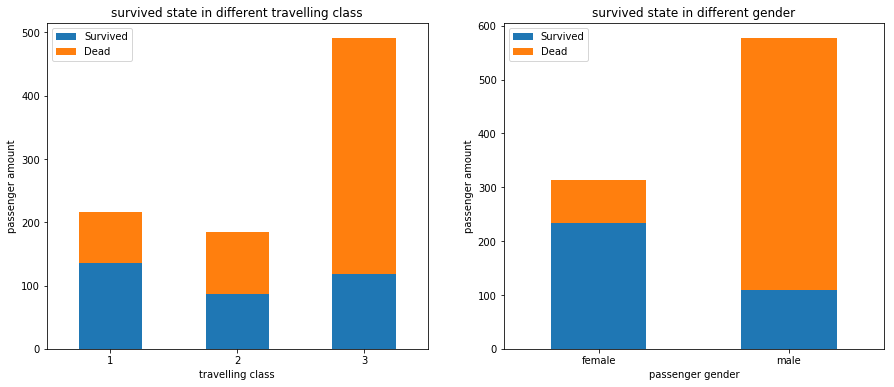

In [11]:
dead = titanic_df.Pclass[titanic_df.Survived == 0].value_counts()
survived = titanic_df.Pclass[titanic_df.Survived == 1].value_counts()
pclass_survived_df = pd.DataFrame({'Survived':survived, 'Dead':dead})

dead = titanic_df.Sex[titanic_df.Survived == 0].value_counts()
survived = titanic_df.Sex[titanic_df.Survived == 1].value_counts()
sex_survived_df = pd.DataFrame({'Survived':survived, 'Dead':dead})


fig, axes = plt.subplots(nrows=1, ncols=2)
pclass_survived_df.plot(ax=axes[0], kind='bar', stacked=True, figsize=(15, 6),
                        title='survived state in different travelling class', rot=0)
axes[0].set_xlabel('travelling class')
axes[0].set_ylabel('passenger amount')


sex_survived_df.plot(ax=axes[1], kind='bar', stacked=True, figsize=(15, 6),
                     title='survived state in different gender', rot=0)
axes[1].set_xlabel('passenger gender')
axes[1].set_ylabel('passenger amount')
plt.show()

In [12]:
# different Pclass survival rate
print(titanic_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()\
                                  .sort_values(by='Survived', ascending=False))

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [13]:
# different gender survival rate
print(titanic_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()\
                                  .sort_values(by='Survived', ascending=False))

      Sex  Survived
0  female  0.742038
1    male  0.188908


### 3. decision tree using scikit-learn predicts 'Survived'

I chose **Sex** and **Pclass** as my two attributes for predicting survivor.

In [14]:
train_df['Sex'].replace({'male': 0, 'female': 1}, inplace=True)
test_df['Sex'].replace({'male': 0, 'female': 1}, inplace=True)

x_train = train_df[['Sex', 'Pclass']].values
y_train = train_df['Survived'].values
x_test = test_df[['Sex', 'Pclass']].values
y_test = test_df['Survived'].values

In [15]:
# the tree can't get better performance when the depth is greater than 2,
# so I set the the parameter ```max_depth``` as 2.
dt_clf = tree.DecisionTreeClassifier(max_depth=2)
dt_clf = dt_clf.fit(x_train, y_train)

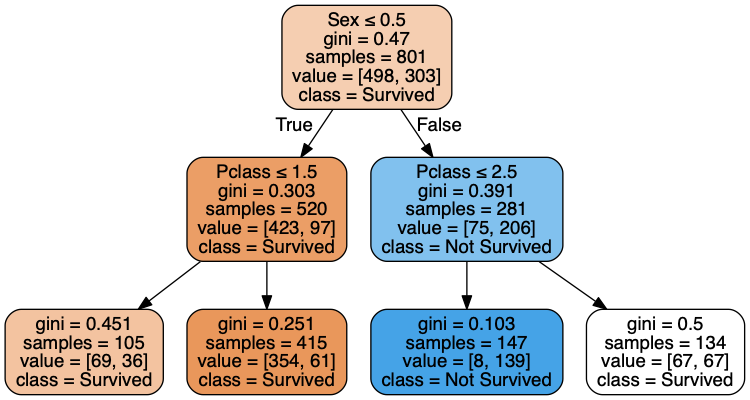

In [16]:
# visualize the decision tree
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
tree.export_graphviz(dt_clf, out_file=dot_data,  
                     feature_names=['Sex', 'Pclass'],  
                     class_names=['Survived', 'Not Survived'],  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [17]:
y_test_pred = dt_clf.predict(x_test)
print('training score = {:.4f}'.format(dt_clf.score(x_train, y_train)))
print('test score = {}'.format(dt_clf.score(x_test, y_test )))
print('accuracy score = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1 score = {}'.format(metrics.f1_score(y_test, y_test_pred)))
print()
print('recall score = {}'.format(metrics.recall_score(y_test, y_test_pred, labels=[1, 0])))
print('precision score = {}'.format(metrics.precision_score(y_test, y_test_pred)))

training score = 0.7853
test score = 0.8
accuracy score = 0.8
f1 score = 0.7096774193548387

recall score = 0.5641025641025641
precision score = 0.9565217391304348


In [18]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_test_pred).ravel()
print(tn, fp, fn, tp)

50 1 17 22


### 4. logistic regression using scikit-learn predicts 'Survived'

In [19]:
lr_clf = LogisticRegression(random_state=42, solver='lbfgs')
lr_clf = lr_clf.fit(x_train, y_train)
y_test_pred = lr_clf.predict(x_test)

In [20]:
print('training score = {:.4f}'.format(lr_clf.score(x_train, y_train)))
print('test score = {}'.format(lr_clf.score(x_test, y_test )))
print('accuracy score = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1 score = {}'.format(metrics.f1_score(y_test, y_test_pred)))
print()
print('recall score = {}'.format(metrics.recall_score(y_test, y_test_pred)))
print('precision score = {}'.format(metrics.precision_score(y_test, y_test_pred)))

training score = 0.7853
test score = 0.8
accuracy score = 0.8
f1 score = 0.7500000000000001

recall score = 0.6923076923076923
precision score = 0.8181818181818182


In [21]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_test_pred).ravel()
print(tn, fp, fn, tp)

45 6 12 27


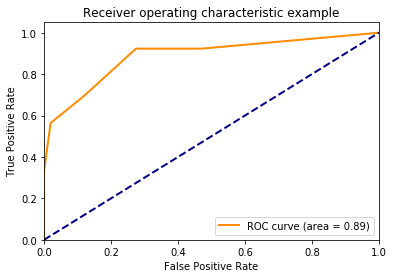

In [22]:
# draw the ROC
y_score = lr_clf.decision_function(x_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

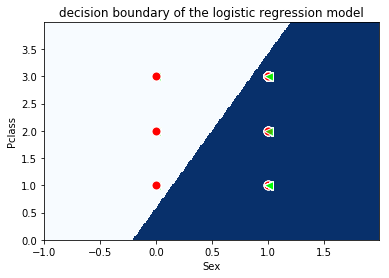

In [23]:
# PLOT the decision boundary
plt.figure()
plt.set_cmap( 'Blues' )

# plot the training points
colours = [ ( 1, 0, 0, 1 ), ( 0, 1, 0, 0.7 ), ( 0, 0, 1, 0.5 ) ]
markers = [ 'o','<','s' ]
for i in range(len(x_train)):
    plt.plot( x_train[i,0], x_train[i,1], marker=markers[y_train[i]], markeredgecolor='w', markerfacecolor=colours[y_train[i]], markersize=9 )
# and also plot the test points
for i in range(len(x_test)):
    plt.plot( x_test[i,0], x_test[i,1], marker=markers[y_test[i]], markeredgecolor='w', markerfacecolor=colours[y_test[i]], markersize=9 )

x0_range = np.arange(-1, 2, 0.01 )
x0_len = len( x0_range ) # save number of items in the x0_range array
x1_range = np.arange(0, 4, 0.01)
x1_len = len( x1_range ) # save number of items in the x1_range array

x_mesh_pairs = np.zeros(( x0_len * x1_len, 2 ))

i = 0
for i1 in range( x1_len ):
    for i0 in range( x0_len ):
        x_mesh_pairs[i] = np.array( [ x0_range[i0], x1_range[i1] ] )
        i += 1
y_hat_pairs = lr_clf.predict(x_mesh_pairs)

x0_mesh, x1_mesh = np.meshgrid(x0_range, x1_range)
y_hat_mesh = y_hat_pairs.reshape( x0_mesh.shape )
plt.pcolormesh( x0_mesh, x1_mesh, y_hat_mesh, shading='flat' )

plt.xlabel('Sex')
plt.ylabel('Pclass')
plt.title('decision boundary of the logistic regression model')
plt.show()
# FIXME: distinguish the different points

### 5. linear regression using scikit-learn predicts 'Age'

Since there are 171 values in attribute **Age** are ```NaN``` , and linear regression model can't handle missing values very well, I used the mean of age for filling them.

In [24]:
nona_titanic_df = titanic_df[titanic_df['Age'].notna()]

The figures showed below indicate the distribution of age are different according to the passenger gender and travelling class. Therefore, I calculated six different mean values corresponding to 3 travelling class and 2 gender.

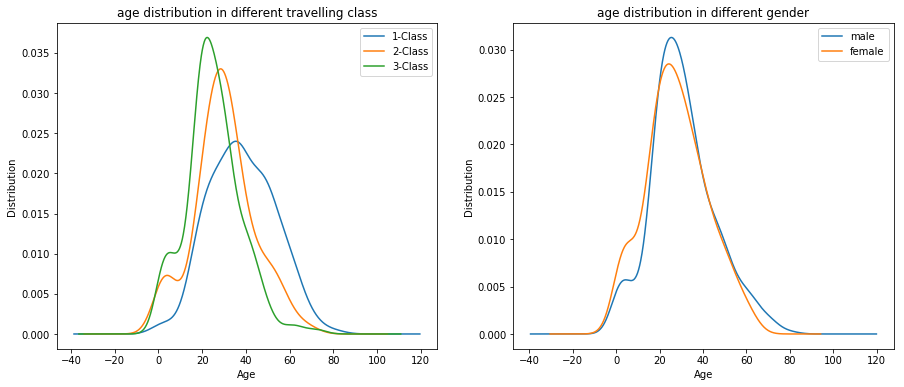

In [25]:
# age distribution in different travelling class
plt.figure(figsize=(15, 6))

plt.subplot(121)
nona_titanic_df.Age[nona_titanic_df.Pclass == 1].plot(kind='kde')   
nona_titanic_df.Age[nona_titanic_df.Pclass == 2].plot(kind='kde')
nona_titanic_df.Age[nona_titanic_df.Pclass == 3].plot(kind='kde')
plt.xlabel('Age')
plt.ylabel('Distribution') 
plt.title('age distribution in different travelling class')
plt.legend(('1-Class', '2-Class','3-Class'),loc='best') 

# age distribution in different gender
plt.subplot(122)
nona_titanic_df.Age[nona_titanic_df.Sex == 'male'].plot(kind='kde')   
nona_titanic_df.Age[nona_titanic_df.Sex == 'female'].plot(kind='kde')
plt.xlabel("Age")
plt.ylabel('Distribution') 
plt.legend(('male', 'female'),loc='best')
plt.title('age distribution in different gender')
plt.show()

In [26]:
# calculate the mean value of different gender and travelling class
age_mean = nona_titanic_df.groupby(by=['Sex', 'Pclass']).mean()['Age']
print(age_mean)

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64


In [27]:
# before filling, there are 
print(train_df['Age'].isna().sum())
# fill missing values in training set
for i in train_df[train_df['Age'].isna()].index.values:
    # first class, male
    if train_df.loc[i, 'Pclass'] == 1 and train_df.loc[i, 'Sex'] == 0:
        train_df.loc[i, 'Age'] = age_mean['male', 1]
    # first class, female
    elif train_df.loc[i, 'Pclass'] == 1 and train_df.loc[i, 'Sex'] == 1:
        train_df.loc[i, 'Age'] = age_mean['female', 1]
    # second class, male
    elif train_df.loc[i, 'Pclass'] == 2 and train_df.loc[i, 'Sex'] == 0:
        train_df.loc[i, 'Age'] = age_mean['male', 2]
    # second class, female
    elif train_df.loc[i, 'Pclass'] == 2 and train_df.loc[i, 'Sex'] == 1:
        train_df.loc[i, 'Age'] = age_mean['female', 2]
    # third class, male
    elif train_df.loc[i, 'Pclass'] == 3 and train_df.loc[i, 'Sex'] == 0:
        train_df.loc[i, 'Age'] = age_mean['male', 3]
    # third class, female
    elif train_df.loc[i, 'Pclass'] == 3 and train_df.loc[i, 'Sex'] == 1:
        train_df.loc[i, 'Age'] = age_mean['female', 3]
print(train_df['Age'].isna().sum())

158
0


In [28]:
# before filling, there are 19 nan in test set
print(test_df['Age'].isna().sum())
# fill missing values in test set
for i in test_df[test_df['Age'].isna()].index.values:
    # first class, male
    if test_df.loc[i, 'Pclass'] == 1 and test_df.loc[i, 'Sex'] == 0:
        test_df.loc[i, 'Age'] = age_mean['male', 1]
    # first class, female
    elif test_df.loc[i, 'Pclass'] == 1 and test_df.loc[i, 'Sex'] == 1:
        test_df.loc[i, 'Age'] = age_mean['female', 1]
    # second class, male
    elif test_df.loc[i, 'Pclass'] == 2 and test_df.loc[i, 'Sex'] == 0:
        test_df.loc[i, 'Age'] = age_mean['male', 2]
    # second class, female
    elif test_df.loc[i, 'Pclass'] == 2 and test_df.loc[i, 'Sex'] == 1:
        test_df.loc[i, 'Age'] = age_mean['female', 2]
    # third class, male
    elif test_df.loc[i, 'Pclass'] == 3 and test_df.loc[i, 'Sex'] == 0:
        test_df.loc[i, 'Age'] = age_mean['male', 3]
    # third class, female
    elif test_df.loc[i, 'Pclass'] == 3 and test_df.loc[i, 'Sex'] == 1:
        test_df.loc[i, 'Age'] = age_mean['female', 3]
print(test_df['Age'].isna().sum())

19
0


 It is obvious from the boxplot of **Fare** that some values are too large to fit the linear model. So I deleted the **Fare** value which is greater than $ upper \, quantile + 1.5*IQR $.

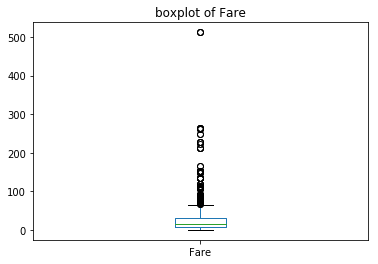

In [29]:
# draw boxplot of Fare
plt.title('boxplot of Fare')
titanic_df.Fare.plot(kind='box')
plt.show()

In [30]:
# calculate the upper limit of Fare
q3 = titanic_df['Fare'].quantile(0.75)
q1 = titanic_df['Fare'].quantile(0.25)
IQR = q3 - q1
upper_limit = q3 + 1.5 * IQR
lower_limit = q1 - 1.5 * IQR
print(upper_limit)
print(lower_limit)
# lower limit is -26.724, which is smaller than 0,
# so no need for cleaning

65.6344
-26.724


In [31]:
before_train_df = train_df.copy()
before_test_df = test_df.copy()

In [32]:
# clean the outlier in training set and test set
for i in train_df['Fare'].index.values:
    if train_df.loc[i, 'Fare'] > upper_limit:
        train_df.drop([i], inplace=True)

for i in test_df['Fare'].index.values:
    if test_df.loc[i, 'Fare'] > upper_limit:
        test_df.drop([i], inplace=True)

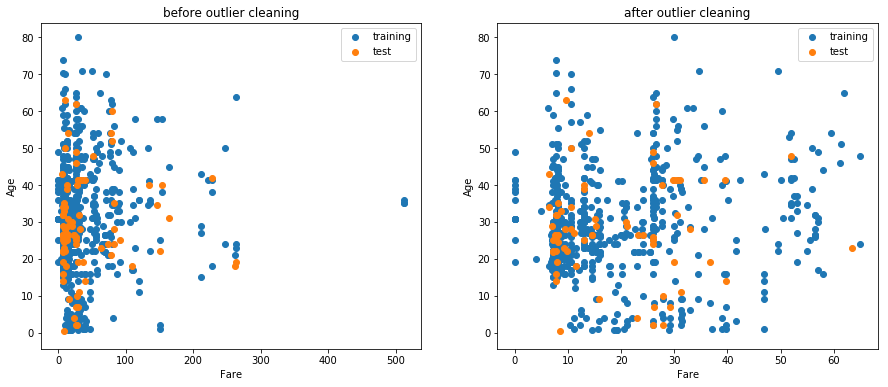

In [33]:
plt.figure(figsize=(15, 6))

# the training data and test data plot before cleaning outlier
plt.subplot(121)
plt.scatter(before_train_df['Fare'], before_train_df['Age'])
plt.scatter(before_test_df['Fare'], before_test_df['Age'])
plt.title('before outlier cleaning')
plt.xlabel('Fare')
plt.ylabel('Age')
plt.legend(('training', 'test'),loc='best')

# the training data and test data plot before cleaning outlier
plt.subplot(122)
plt.scatter(train_df['Fare'], train_df['Age'])
plt.scatter(test_df['Fare'], test_df['Age'])
plt.title('after outlier cleaning')
plt.xlabel('Fare')
plt.ylabel('Age')
plt.legend(('training', 'test'),loc='best')
plt.show()

After the data processing, the scatter plot of **Fare** and **Age** became more reasonable. The training set has 703 values left and the test set has 72 values left.

In [34]:
# extract x and y data for training and test
x_train = train_df['Fare'].values
x_train = x_train.reshape((-1, 1))
y_train = train_df['Age'].values
print(x_train.shape)

x_test = test_df['Fare'].values
x_test = x_test.reshape((-1, 1))
y_test = test_df['Age'].values
print(x_test.shape)

(703, 1)
(72, 1)


In [35]:
reg = LinearRegression().fit(x_train, y_train)
y_test_pred = reg.predict(x_test)
print('R2: {:.4f}'.format(metrics.r2_score(y_test, y_test_pred)))
print('Mean Square Error: {:.4f}'.format(metrics.mean_squared_error(y_test, y_test_pred)))

R2: -0.0094
Mean Square Error: 172.6351


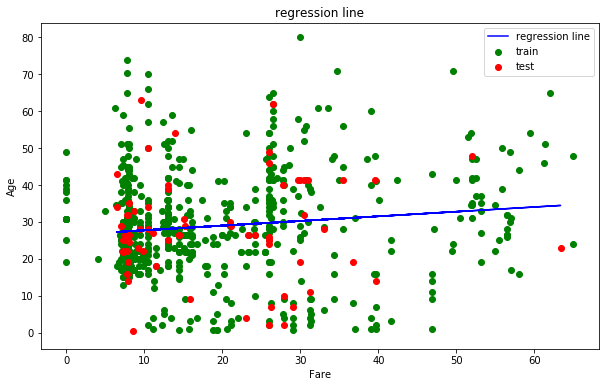

In [36]:
# plot the regression line and data
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, c='G')
plt.scatter(x_test, y_test, c='R')
plt.plot(x_test, y_test_pred, c='B')

plt.title('regression line')
plt.xlabel('Fare')
plt.ylabel('Age')
plt.legend(('regression line', 'train', 'test'),loc='best')
plt.show()

The R2 score of my linear regression model is -0.0094. The mean squared error is 172.6351. The blue line in the plot below is the regression line.